In [1]:
import numpy as np
import rnn_utils

# 1. 搭建循环神经网络

## 1.1 RNN

In [8]:
def rnn_cell_forward(xt, a_prev, parameters):
    # 从“parameters”获取参数
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]
    
    a_next = np.tanh(np.dot(Wax, xt) + np.dot(Waa, a_prev) + ba)
    yt_pred = rnn_utils.softmax(np.dot(Wya, a_next) + by)
    
    cache = (a_next, a_prev, xt, parameters)
    return a_next, yt_pred, cache

In [4]:
def rnn_forward(x, a0, parameters):
    caches = []
    
    n_x, m, T_x = x.shape
    n_y, n_a = parameters['Wya'].shape
    a = np.zeros([n_a, m, T_x])
    y_pred = np.zeros([n_y, m, T_x])
    
    a_next = a0
    
    for t in range(T_x):
        a_next, yt_pred, cache = rnn_cell_forward(x[:,:,t], a_next, parameters)
        
        a[:,:,t] = a_next
        y_pred[:,:,t] = yt_pred
        caches.append(cache)
    
    caches = (caches, x)
    return a, y_pred, caches

In [5]:
np.random.seed(1)
x = np.random.randn(3,10,4)
a0 = np.random.randn(5,10)
Waa = np.random.randn(5,5)
Wax = np.random.randn(5,3)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Waa": Waa, "Wax": Wax, "Wya": Wya, "ba": ba, "by": by}

a, y_pred, caches = rnn_forward(x, a0, parameters)
print("a[4][1] = ", a[4][1])
print("a.shape = ", a.shape)
print("y_pred[1][3] =", y_pred[1][3])
print("y_pred.shape = ", y_pred.shape)
print("caches[1][1][3] =", caches[1][1][3])
print("len(caches) = ", len(caches))


a[4][1] =  [-0.99999375  0.77911235 -0.99861469 -0.99833267]
a.shape =  (5, 10, 4)
y_pred[1][3] = [0.79560373 0.86224861 0.11118257 0.81515947]
y_pred.shape =  (2, 10, 4)
caches[1][1][3] = [-1.1425182  -0.34934272 -0.20889423  0.58662319]
len(caches) =  2


## 1.2 LSTM

In [15]:
def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    '''
    parameters -- 字典类型的变量，包含了：
                Wf -- 遗忘门的权值，维度为(n_a, n_a + n_x)
                bf -- 遗忘门的偏置，维度为(n_a, 1)
                Wi -- 更新门的权值，维度为(n_a, n_a + n_x)
                bi -- 更新门的偏置，维度为(n_a, 1)
                Wc -- 第一个“tanh”的权值，维度为(n_a, n_a + n_x)
                bc -- 第一个“tanh”的偏置，维度为(n_a, n_a + n_x)
                Wo -- 输出门的权值，维度为(n_a, n_a + n_x)
                bo -- 输出门的偏置，维度为(n_a, 1)
                Wy -- 隐藏状态与输出相关的权值，维度为(n_y, n_a)
                by -- 隐藏状态与输出相关的偏置，维度为(n_y, 1)
    '''
    Wf = parameters["Wf"]
    bf = parameters["bf"]
    Wi = parameters["Wi"]
    bi = parameters["bi"]
    Wc = parameters["Wc"]
    bc = parameters["bc"]
    Wo = parameters["Wo"]
    bo = parameters["bo"]
    Wy = parameters["Wy"]
    by = parameters["by"]

    n_x, m = xt.shape
    n_y, n_a = Wy.shape
    
    concat = np.zeros([n_a+n_x, m])
    concat[:n_a, :] = a_prev
    concat[n_a:, :] = xt
    
    # 计算遗忘门、更新门、输出门
    ft = rnn_utils.sigmoid(np.dot(Wf, concat) + bf)
    it = rnn_utils.sigmoid(np.dot(Wi, concat) + bi)
    ot = rnn_utils.sigmoid(np.dot(Wo, concat) + bo)
    
    ct_wave = np.tanh(np.dot(Wc, concat) + bc)
    c_next = ft * c_prev + it * ct_wave
    a_next = ot * np.tanh(c_next)
    yt_pred = rnn_utils.softmax(np.dot(Wy, a_next) + by)
    
    # 保存包含了反向传播所需要的参数
    cache = (a_next, c_next, a_prev, c_prev, ft, it, ct_wave, ot, xt, parameters)
    
    return a_next, c_next, yt_pred, cache

In [17]:
def lstm_forward(x, a0, parameters):
    caches = []
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wy"].shape
    
    a = np.zeros([n_a, m, T_x])
    c = np.zeros([n_a, m, T_x])
    y = np.zeros([n_y, m, T_x])
    
    a_next = a0
    c_next = np.zeros([n_a, m])
    
    for t in range(T_x):
        a_next, c_next, yt_pred, cache = lstm_cell_forward(x[:,:,t], a_next, c_next, parameters)
        
        a[:,:,t] = a_next
        c[:,:,t] = c_next
        y[:,:,t] = yt_pred
        caches.append(cache)
        
    # 保存反向传播需要的参数
    caches = (caches, x)
    
    return a, y, c, caches

In [18]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a0 = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a0, parameters)
print("a[4][3][6] = ", a[4][3][6])
print("a.shape = ", a.shape)
print("y[1][4][3] =", y[1][4][3])
print("y.shape = ", y.shape)
print("caches[1][1[1]] =", caches[1][1][1])
print("c[1][2][1]", c[1][2][1])
print("len(caches) = ", len(caches))


a[4][3][6] =  0.17211776753291672
a.shape =  (5, 10, 7)
y[1][4][3] = 0.9508734618501101
y.shape =  (2, 10, 7)
caches[1][1[1]] = [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] -0.8555449167181981
len(caches) =  2


## 1.3 循环神经网络的反向传播（略）

# 2 字符级语言模型——恐龙岛

In [1]:
import numpy as np
import time
import random
import cllm_utils

In [7]:
data = open(r"dinos.txt", "r").read()
data = data.lower()
chars = list(set(data))

data_size, vocab_size = len(data), len(chars)
print("共计有%d个字符，唯一字符有%d个"%(data_size,vocab_size))

共计有19909个字符，唯一字符有27个


In [6]:
char_to_ix = {ch:i for i, ch in enumerate(sorted(chars))}
ix_to_char = {i:ch for i, ch in enumerate(sorted(chars))}

print(char_to_ix)
print(ix_to_char)

{'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [3]:
def clip(gradients, maxValue):
    """
    使用maxValue来修剪梯度
    
    参数：
        gradients -- 字典类型，包含了以下参数："dWaa", "dWax", "dWya", "db", "dby"
        maxValue -- 阈值，把梯度值限制在[-maxValue, maxValue]内
        
    返回：
        gradients -- 修剪后的梯度
    """
    # 获取参数
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
    
    # 梯度修剪
    for gradient in [dWaa, dWax, dWya, db, dby]:
        np.clip(gradient, -maxValue, maxValue, out=gradient)

    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients

In [4]:
def sample(parameters, char_to_ix, seed):
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size, n_a = Wya.shape
    
    idx_newline = char_to_ix["\n"]
    idx = -1
    indices = []
    counter = 0
    
    a_prev = np.zeros((n_a,1))
    # 创建独热向量x
    x = np.zeros((vocab_size,1))
    
    while idx != idx_newline and counter < 50:
        a = np.tanh(np.dot(Waa,a_prev) + np.dot(Wax,x) + b)
        z = np.dot(Wya,a) + by
        y = cllm_utils.softmax(z)
        
        np.random.seed(counter + seed)
        idx = np.random.choice(list(range(vocab_size)),p=y.ravel())
        indices.append(idx)
        
        x = np.zeros((vocab_size,1))
        x[idx] = 1
        a_prev = a
        
        seed += 1
        counter += 1
        
    if(counter == 50):
        indices.append(idx_newline)
    return indices

In [8]:
np.random.seed(2)
_, n_a = 20, 100
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}


indices = sample(parameters, char_to_ix, 0)
print("Sampling:")
print("list of sampled indices:", indices)
print("list of sampled characters:", [ix_to_char[i] for i in indices])


Sampling:
list of sampled indices: [12, 17, 24, 14, 13, 9, 10, 22, 24, 6, 13, 11, 12, 6, 21, 15, 21, 14, 3, 2, 1, 21, 18, 24, 7, 25, 6, 25, 18, 10, 16, 2, 3, 8, 15, 12, 11, 7, 1, 12, 10, 2, 7, 7, 11, 17, 24, 12, 3, 1, 0]
list of sampled characters: ['l', 'q', 'x', 'n', 'm', 'i', 'j', 'v', 'x', 'f', 'm', 'k', 'l', 'f', 'u', 'o', 'u', 'n', 'c', 'b', 'a', 'u', 'r', 'x', 'g', 'y', 'f', 'y', 'r', 'j', 'p', 'b', 'c', 'h', 'o', 'l', 'k', 'g', 'a', 'l', 'j', 'b', 'g', 'g', 'k', 'q', 'x', 'l', 'c', 'a', '\n']


## 语言模型

In [20]:
def optimize(X, Y, a_prev, parameters,learning_rate=0.01):
    """
    执行训练模型的单步优化。
    
    参数：
        X -- 整数列表，其中每个整数映射到词汇表中的字符。
        Y -- 整数列表，与X完全相同，但向左移动了一个索引。
        a_prev -- 上一个隐藏状态
        parameters -- 字典，包含了以下参数：
                        Wax -- 权重矩阵乘以输入，维度为(n_a, n_x)
                        Waa -- 权重矩阵乘以隐藏状态，维度为(n_a, n_a)
                        Wya -- 隐藏状态与输出相关的权重矩阵，维度为(n_y, n_a)
                        b -- 偏置，维度为(n_a, 1)
                        by -- 隐藏状态与输出相关的权重偏置，维度为(n_y, 1)
        learning_rate -- 模型学习的速率
    
    返回：
        loss -- 损失函数的值（交叉熵损失）
        gradients -- 字典，包含了以下参数：
                        dWax -- 输入到隐藏的权值的梯度，维度为(n_a, n_x)
                        dWaa -- 隐藏到隐藏的权值的梯度，维度为(n_a, n_a)
                        dWya -- 隐藏到输出的权值的梯度，维度为(n_y, n_a)
                        db -- 偏置的梯度，维度为(n_a, 1)
                        dby -- 输出偏置向量的梯度，维度为(n_y, 1)
        a[len(X)-1] -- 最后的隐藏状态，维度为(n_a, 1)
    """
    loss,cache = cllm_utils.rnn_forward(X, Y, a_prev, parameters)
    
    grads, a = cllm_utils.rnn_backward(X, Y, parameters, cache)
    
    # 梯度修剪
    grads = clip(grads, 5)
    
    parameters = cllm_utils.update_parameters(parameters, grads, learning_rate)
    
    return loss,grads,a[len(X)-1]

In [19]:
np.random.seed(1)
vocab_size, n_a = 27, 100
a_prev = np.random.randn(n_a, 1)
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}
X = [12,3,5,11,22,3]
Y = [4,14,11,22,25, 26]

loss, gradients, a_last = optimize(X, Y, a_prev, parameters, learning_rate = 0.01)
print("Loss =", loss)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("np.argmax(gradients[\"dWax\"]) =", np.argmax(gradients["dWax"]))
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])
print("a_last[4] =", a_last[4])


Loss = 126.50397572165345
gradients["dWaa"][1][2] = 0.19470931534725341
np.argmax(gradients["dWax"]) = 93
gradients["dWya"][1][2] = -0.007773876032004315
gradients["db"][4] = [-0.06809825]
gradients["dby"][1] = [0.01538192]
a_last[4] = [-1.]


In [27]:
def model(data, ix_to_char, char_to_ix, num_iterations=3500, 
          n_a=50, dino_names=7,vocab_size=27):
    """
    训练模型并生成恐龙名字
    
    参数：
        data -- 语料库
        ix_to_char -- 索引映射字符字典
        char_to_ix -- 字符映射索引字典
        num_iterations -- 迭代次数
        n_a -- RNN单元数量
        dino_names -- 每次迭代中采样的数量
        vocab_size -- 在文本中的唯一字符的数量
    
    返回：
        parameters -- 学习后了的参数
    """
    n_x,n_y = vocab_size,vocab_size
    
    # 初始化参数
    parameters = cllm_utils.initialize_parameters(n_a, n_x, n_y)
    
    # 初始化损失
    losses = []
    loss = cllm_utils.get_initial_loss(vocab_size, dino_names)
    
    with open("dinos.txt") as f:
        examples = f.readlines()
    examples = [x.lower().strip() for x in examples]
    
    np.random.seed(0)
    np.random.shuffle(examples)
    
    a_prev = np.zeros((n_a,1))
    
    for j in range(num_iterations):
        index = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[index]]
        Y = X[1:] + [char_to_ix["\n"]]
        
        curr_loss,grads,a_prev = optimize(X, Y, a_prev, parameters)
        
        # 使用延迟来保持损失平滑,这是为了加速训练。
        loss = cllm_utils.smooth(loss, curr_loss)
        losses.append(loss)
        
        # 每2000次迭代，通过sample()生成“\n”字符，检查模型是否学习正确
        if j % 2000 == 0:
            print("第" + str(j+1) + "次迭代，损失值为：" + str(loss))
            
            seed = 0
            for name in range(dino_names):
                # 采样
                sampled_indices = sample(parameters, char_to_ix, seed)
                cllm_utils.print_sample(sampled_indices, ix_to_char)
                
                # 为了得到相同的效果，随机种子+1
                seed += 1
            
            print("\n")
        
    import matplotlib.pyplot as plt
    plt.plot(np.squeeze(losses))
    plt.show()
    
    return parameters

D:\tech\Anaconda3\envs\pytorch1.4-cuda10.1\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


第1次迭代，损失值为：23.087336085484605
Nkzxwtdmfqoeyhsqwasjkjvu
Kneb
Kzxwtdmfqoeyhsqwasjkjvu
Neb
Zxwtdmfqoeyhsqwasjkjvu
Eb
Xwtdmfqoeyhsqwasjkjvu


第2001次迭代，损失值为：27.884160491415773
Liusskeomnolxeros
Hmdaairus
Hytroligoraurus
Lecalosapaus
Xusicikoraurus
Abalpsamantisaurus
Tpraneronxeros


第4001次迭代，损失值为：25.90181489335302
Mivrosaurus
Inee
Ivtroplisaurus
Mbaaisaurus
Wusichisaurus
Cabaselachus
Toraperlethosdarenitochusthiamamumamaon


第6001次迭代，损失值为：24.60877890083239
Onwusceomosaurus
Lieeaerosaurus
Lxussaurus
Oma
Xusteonosaurus
Eeahosaurus
Toreonosaurus


第8001次迭代，损失值为：24.070350147705284
Onxusichepriuon
Kilabersaurus
Lutrodon
Omaaerosaurus
Xutrcheps
Edaksoje
Trodiktonus




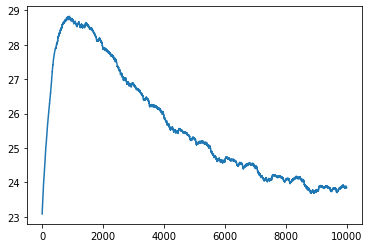

执行了：0分8秒


D:\tech\Anaconda3\envs\pytorch1.4-cuda10.1\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [29]:
#开始时间
start_time = time.clock()

#开始训练
parameters = model(data, ix_to_char, char_to_ix, num_iterations=10000)

#结束时间
end_time = time.clock()

#计算时差
minium = end_time - start_time

print("执行了：" + str(int(minium / 60)) + "分" + str(int(minium%60)) + "秒")
